# Triangulation

## Imports

In [356]:
import numpy as np
import xml.etree.ElementTree as ET
import cv2
from PIL import Image

In [91]:
from iterative_eigen.iterative_eigen import IterativeEigen
from iterative_ls.iterative_ls import IterativeLS
from linear_eigen.linear_eigen import LinearEigen
from linear_ls.linear_ls import LinearLS
from poly.poly import Poly
from poly_abs.poly_abs import PolyAbs

## Utilities

### Camera matrix
Tsai model camera matrix

In [357]:
def intrinsic_matrix(f, cx, cy):
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]], dtype=np.float64)

def rotation(rx, ry, rz):
    R = np.zeros((3, 3))
    R[0, 0] = np.cos(ry) * np.cos(rz)
    R[0, 1] = np.cos(rz) * np.sin(rx) * np.sin(ry) - np.cos(rx) * np.sin(rz)
    R[0, 2] = np.sin(rx) * np.sin(rz) + np.cos(rx) * np.cos(rz) * np.sin(ry)
    R[1, 0] = np.cos(ry) * np.sin(rz)
    R[1, 1] = np.sin(rx) * np.sin(ry) * np.sin(rz) + np.cos(rx) * np.cos(rz)
    R[1, 2] = np.cos(rx) * np.sin(ry) * np.sin(rz) - np.cos(rz) * np.sin(rx)
    R[2, 0] = -np.sin(ry)
    R[2, 1] = np.cos(ry) * np.sin(rx)
    R[2, 2] = np.cos(rx) * np.cos(ry)
    return R

def camera(focal, kappa1, cx, cy, sx, tx, ty, tz, rx, ry, rz, **kwargs):
    K = intrinsic_matrix(focal, cx, cy)
    t = np.array([[tx], [ty], [tz]], dtype=np.float64)
    R = rotation(rx, ry, rz)
    Rt = np.hstack((R, t))
    return K @ Rt

### xml parameters parser

In [337]:
def get_parameters(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    attribs = {}
    for child in root:
        attribs = dict(**attribs, **child.attrib)
    return {key: float(attribs[key]) for key in attribs}

## Points taken from images

In [358]:
def add_marker(arr, point, radius=3, color=[0, 255, 255]):
    i, j = point[0], point[1]
    arr[i-radius:i+radius, j-radius:j+radius] = color

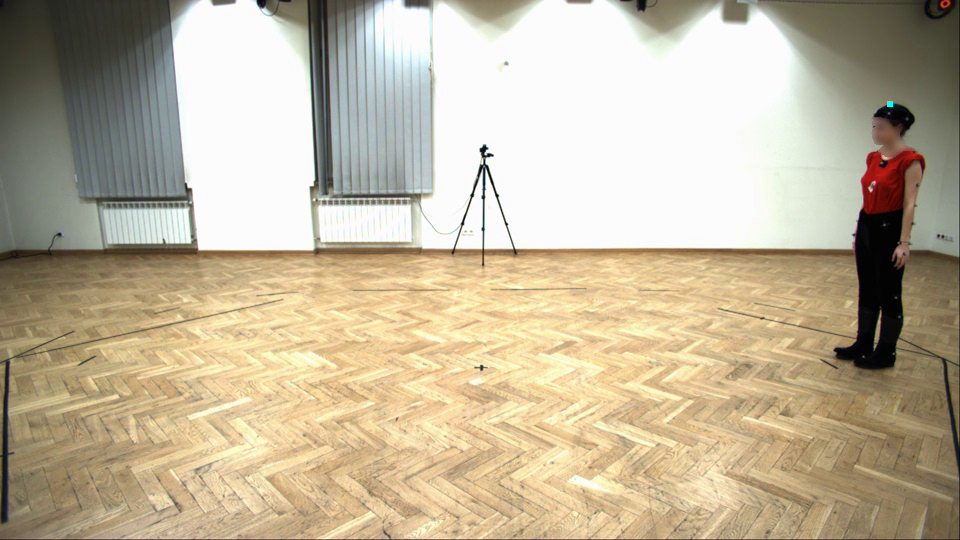

In [359]:
image = Image.open('images/c1-0195.png')

arr = np.array(image)
point0 = (104, 890)
add_marker(arr, point0)

Image.fromarray(arr).show()
point0 = np.array(point0, dtype=np.float64)[::-1]

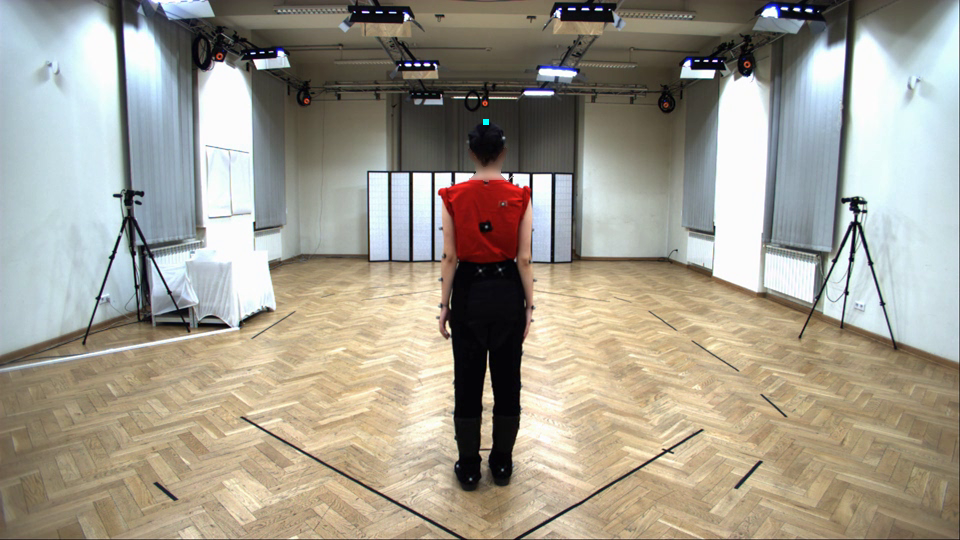

In [360]:
image = Image.open('images/c2-0195.png')

arr = np.array(image)
point1 = (122, 486)
add_marker(arr, point1)

Image.fromarray(arr).show()
point1 = np.array(point1, dtype=np.float64)[::-1]

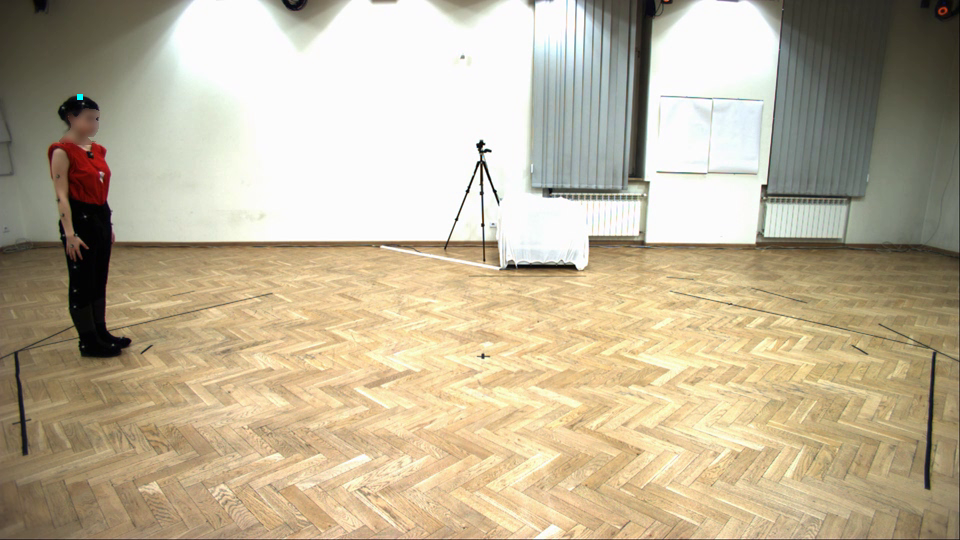

In [361]:
image = Image.open('images/c3-0195.png')

arr = np.array(image)
point2 = (97, 80)
add_marker(arr, point2)

Image.fromarray(arr).show()
point2 = np.array(point2, dtype=np.float64)[::-1]

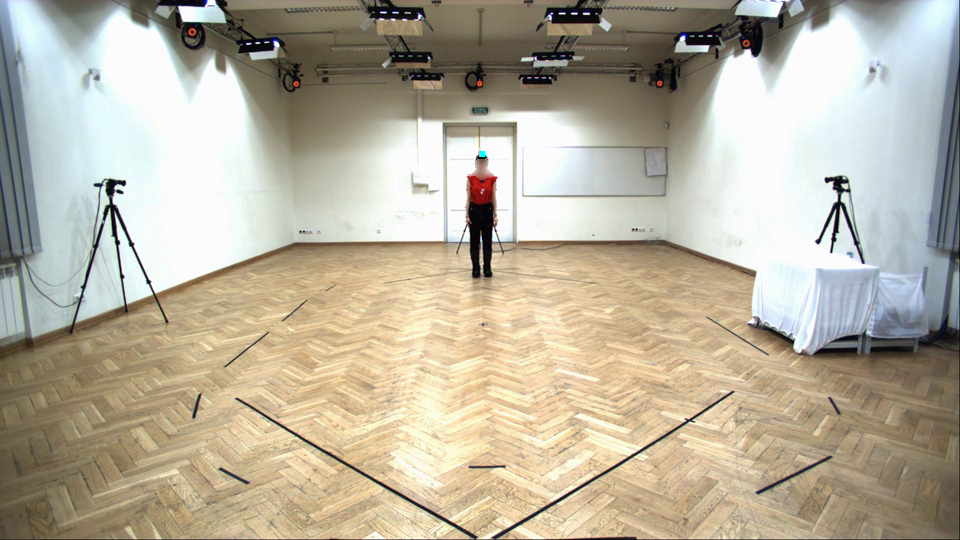

In [362]:
image = Image.open('images/c4-0195.png')

arr = np.array(image)
point3 = (154, 482)
add_marker(arr, point3)

Image.fromarray(arr).show()
point3 = np.array(point3, dtype=np.float64)[::-1]

## Camera matrices

In [355]:
p0 = camera(**get_parameters('images/c1.xml'))
p1 = camera(**get_parameters('images/c2.xml'))
p2 = camera(**get_parameters('images/c3.xml'))
p3 = camera(**get_parameters('images/c4.xml'))

## Results Obtained with opencv

In [352]:
def homogenize3D(point):
    return point / point[3]

In [353]:
res0 = cv2.triangulatePoints(projMatr1=p0,
                             projMatr2=p1,
                             projPoints1=point0,
                             projPoints2=point1)

res1 = cv2.triangulatePoints(projMatr1=p1,
                             projMatr2=p2,
                             projPoints1=point1,
                             projPoints2=point2)

res2 = cv2.triangulatePoints(projMatr1=p2,
                             projMatr2=p3,
                             projPoints1=point2,
                             projPoints2=point3)

res3 = cv2.triangulatePoints(projMatr1=p3,
                             projMatr2=p0,
                             projPoints1=point3,
                             projPoints2=point0)
print(homogenize3D(res0))
print(homogenize3D(res1))
print(homogenize3D(res2))
print(homogenize3D(res3))

[[-1.20046082e+02]
 [ 2.34984794e+03]
 [ 1.62487614e+03]
 [ 1.00000000e+00]]
[[-1.07068991e+02]
 [ 2.41626195e+03]
 [ 1.60472340e+03]
 [ 1.00000000e+00]]
[[-9.82410963e+01]
 [ 2.41712770e+03]
 [ 1.59364155e+03]
 [ 1.00000000e+00]]
[[-1.01462388e+02]
 [ 2.33426878e+03]
 [ 1.60707507e+03]
 [ 1.00000000e+00]]


## Own implementation

In [373]:
def calculate(matrix1, matrix2, point1, point2, Method):
    method = Method(matrix1, matrix2)
    res = method.triangulate_point(point1, point2)
    print(f"Result: {res} Method: {Method.__name__}")


def calculate_cv2(matrix1, matrix2, point1, point2):
    res = cv2.triangulatePoints(p0, p1, point0, point1)
    hom_res = homogenize3D(res)
    list_res = [float(a) for a in hom_res]
    print(f"Result: {list_res[:3]} Method: opencv")

In [376]:

calculate(p0, p1, point0, point1, Poly)
calculate(p0, p2, point0, point2, Poly)
calculate(p0, p3, point0, point3, Poly)
print()

calculate(p0, p1, point0, point1, PolyAbs)
calculate(p0, p2, point0, point2, PolyAbs)
calculate(p0, p3, point0, point3, PolyAbs)
print()

calculate(p0, p1, point0, point1, LinearLS)
calculate(p0, p2, point0, point2, LinearLS)
calculate(p0, p3, point0, point3, LinearLS)
print()

calculate(p0, p1, point0, point1, LinearEigen)
calculate(p0, p2, point0, point2, LinearEigen)
calculate(p0, p3, point0, point3, LinearEigen)
print()

calculate(p0, p1, point0, point1, IterativeLS)
calculate(p0, p2, point0, point2, IterativeLS)
calculate(p0, p3, point0, point3, IterativeLS)
print()

calculate(p0, p1, point0, point1, IterativeEigen)
calculate(p0, p2, point0, point2, IterativeEigen)
calculate(p0, p3, point0, point3, IterativeEigen)
print()

Result: (-32.809780287842955, 2362.138360207869, 1974.981008427128) Method: Poly
Result: (-122.03367586121426, 2360.6156110864913, 1721.3821294622053) Method: Poly
Result: (-100.96152409439698, 2333.214972272489, 1615.4533241930105) Method: Poly

Result: (-113.69767244448458, 2327.874236928089, 1659.0652848000211) Method: PolyAbs
Result: (-146.63653906729843, 2377.887899914864, 1601.2261535884634) Method: PolyAbs
Result: (-101.17598023622476, 2333.664441074732, 1611.883379808309) Method: PolyAbs

Result: (-120.04608198089333, 2349.8479447876516, 1624.876143707591) Method: LinearLS
Result: (-152.92384725824303, 2379.0022560892394, 1581.0110399248424) Method: LinearLS
Result: (-101.46238837100226, 2334.2687818622103, 1607.0750738278418) Method: LinearLS

Result: (-120.04608198089427, 2349.8479447876534, 1624.8761437075902) Method: LinearEigen
Result: (-152.92384725824326, 2379.002256089241, 1581.011039924843) Method: LinearEigen
Result: (-101.46238837100135, 2334.268781862209, 1607.07507